# Custom Potentials

For development work, you may be applying operators that are not directly supported by PhaseFunc (most efficient because the entries are generated on the fly and never stored). Sometimes you can reinterpret your operator such that it matches an existing PhaseFunc. If not, there are a couple ways around it:
- just load the contents of the register into a `numpy.ndarray`, manipulate it in python, and load it back into the register during your SO-QFT loop. BE WARNED - pulling the state out of the qubits, modifying, then putting it back in is a very slow process.
- there are two ways to implement arbitary operators on `pyQuEST`:
    1. `DiagonalOperator`, an operator which acts on the entire $n$-qubit QuEST register, generated from only a flattened 1D array of the diagonal elements length $2^{n}$. The operator object is only of the same size as the statevector
    2. `MatrixOperator`, a matrix that is multiplied onto any specified target qubits. In the real space picture, if you don't have a huge number of qubits and your operators are separable by e.g. particle registers, this might be a good place to start. But you won't be able to store many such matricies if your system is large!

In [26]:
import pyquest
import numpy as np
import math
from numpy.polynomial.hermite import hermval
from tqdm.notebook import tqdm

In [27]:
def harmonic_osc_1D(x, n, m, k, xc):
    """Generates the eigenfunction of the harmonic oscillator system.
    Arguments
    x: is a space coordinate.
    n: is the vibrational quantum number, for this case only v=0 is considered.
    m: is the (reduced) mass of the system.
    k: is the force constant of the harmonic potential.
    xc: is the equilibrium separation.
    """

    hermite_sum = np.zeros(n+1)
    hermite_sum[-1] = 1

    return 1/(2**n * math.factorial(n))**0.5 * (((m*k)**0.5)/np.pi)**0.25 * np.exp(-(x-xc)**2 * ((m*k)**0.5)/2) * hermval((m*k)**0.25 * (x-xc),hermite_sum)

In [28]:
# define spatial grid
L = 15 # box size is 10
n_qubits = 5 # per spatial dimension!

dx = L/(2**n_qubits)
x_grid = np.array([dx*n for n in range(int(2**n_qubits))])

# define wavefunction in 1D
psi_x = harmonic_osc_1D(x_grid, n=0, m=1, k=0.1, xc=L/2)
# tensor up to form 2D wavefunction in this separable case
psi_2D = np.tensordot(psi_x, psi_x, axes=0)

# we normalise the wavefunction so that psi_2D itself sums to 1 on a quantum computer.
psi_2D = psi_2D * np.sqrt(dx**2)
np.sum(abs(psi_2D)**2)


0.9999999931607291

In [29]:
from pyquest import Register

reg_init = Register(n_qubits + n_qubits) # 2x5 qubits!
reg_init[:] = psi_2D.flatten()

In [30]:
from qarsen_lite.unitaries import gen_QFT_circ, gen_Quadratic_PhaseFunc

In [31]:
from pyquest.operators import MatrixOperator

In the following example, we generate the propagator for a custom potential (which is actually just the harmonic potential). This should reproduce the result from the first notebook

In [32]:
def gen_propagators(n_qubits, dx, xc, dt, m, k):
    """
    Specific for 1 particle in 2D harmonic potential, first order trotter - edit as necessary to generalise
    """
    # qubit targets
    init_qbit_idx = 0
    targets = []
    for _ in range(2):
        targets.append(list(range(init_qbit_idx, init_qbit_idx+n_qubits)))
        init_qbit_idx += n_qubits
    
    # QFT circuits
    cQFT_circs = [gen_QFT_circ(targets[d][0], targets[d][-1]) for d in range(2)]
    icQFT_circs = [circ.inverse for circ in cQFT_circs]
    # Kinetic propagator
    dp = 2*np.pi/(2**n_qubits * dx)
    pc = 2**n_qubits * dp / 2 # calculate the centre of the momentum space
    coeff = -dt/(2*m)
    K_props = [gen_Quadratic_PhaseFunc(targets[d], dp, coeff, pc) for d in range(2)]

    # Potential 
    n_kets = int(2**n_qubits)
    coeff = k*dt/2
    x_grid = np.array([n*dx for n in range(n_kets)])
    expV_array = np.exp(-1j * coeff * (x_grid-xc)**2) # define custom potential propagator
    expV_matrix = np.zeros((n_kets, n_kets), np.complex128)
    np.fill_diagonal(expV_matrix, expV_array) # convert to diagonal matrix
    V_props = [MatrixOperator(targets[d], expV_matrix) for d in range(2)]

    return cQFT_circs, icQFT_circs, K_props, V_props

In [33]:
def apply_single_step(reg, qft_circs, iqft_circs, K_props, V_props):
    """
    """
    for qft in qft_circs:
        reg.apply_circuit(qft)
    for k in K_props:
        reg.apply_operator(k)
    for iqft in reversed(iqft_circs):
        reg.apply_circuit(iqft)
    
    for v in V_props:
        reg.apply_operator(v)

In [34]:
def U_RTE(reg_init, n_qubits, dx, t_tot, n_steps, xc, m, k, sample_every=10):
    """
    """
    dt = t_tot/n_steps # time resolution
    reg = Register(copy_reg=reg_init) # copy initial register
    Qft, iQft, K, V = gen_propagators(n_qubits, dx, xc, dt, m, k) # generate propagators

    autocorrelation = []
    print("Running SO-QFT propagation...")
    for n in tqdm(range(n_steps)):
        apply_single_step(reg, Qft, iQft, K, V)

        # saving autocorrelation
        if n%sample_every==0:
            autocorrelation.append(reg*reg_init)
    print("Done!")
    return autocorrelation

In [35]:
t_tot = 50
n_steps = 500
sample_every=10
auto = U_RTE(reg_init, 
             n_qubits, 
             dx, 
             t_tot=t_tot, 
             n_steps=n_steps, 
             xc=L/2, 
             m=1, 
             k=0.1, 
             sample_every=sample_every)

Running SO-QFT propagation...


  0%|          | 0/500 [00:00<?, ?it/s]

Done!


In [36]:
import matplotlib.pyplot as plt

Text(0.5, 0, 't')

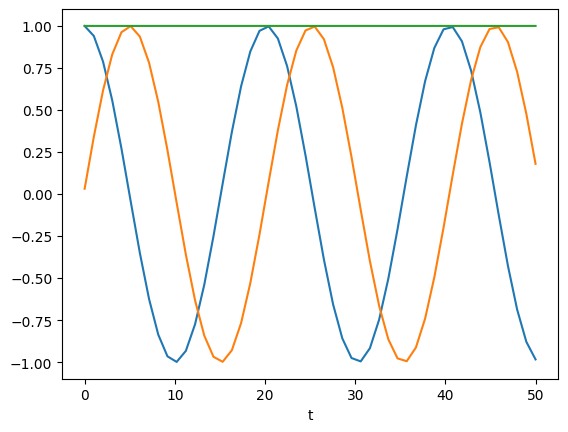

In [12]:
t_grid = np.linspace(0, t_tot, int(n_steps/sample_every))
plt.plot(t_grid, np.real(auto))
plt.plot(t_grid, np.imag(auto))
plt.plot(t_grid, np.abs(auto))
plt.xlabel("t")